In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# install spark in google colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
# !ls
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install spark_sklearn
!pip install pyspark

     |████████████████████████████████| 4.9MB 5.4MB/s 
  Created wheel for spark-sklearn: filename=spark_sklearn-0.3.0-cp36-none-any.whl size=30592 sha256=65f4df668ee7e9a0ea89a4a5e66824fdcfa3cba03821421a508dfa5ef48890f2
  Stored in directory: /root/.cache/pip/wheels/64/28/e8/cb0250888675c630786f932dcc63ed96ac1aca299bcfb7235f
Successfully built spark-sklearn
ERROR: yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
ERROR: imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
  Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
     |████████████████████████████████| 217.8MB 54kB/s 
     |████████████████████████████████| 204kB 50.3MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=f68e4b735c817523e8b8491b8de97805c05da6ac2d4889ed

In [0]:
# set up spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [4]:
# library

import time
from scipy import stats
import pyspark
from pyspark import SparkContext, SparkConf
sc = pyspark.SparkContext()
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.


In [5]:
training = pd.read_csv("/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/Dataset/training/trainingSet_noEmpty.csv")
testing = pd.read_csv("/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/Dataset/testing/testingSet_noEmpty.csv")

print(training.shape)
print(training.columns)
print()
print(testing.shape)
print(testing.columns)

(2690, 123)
Index(['Spanish Div', 'Year', 'Month', 'Day', 'FTHG', 'FTAG', 'HTHG', 'HTAG',
       'HS', 'AS',
       ...
       'AwayTeam_Sociedad', 'AwayTeam_Sp Gijon', 'AwayTeam_Valencia',
       'AwayTeam_Valladolid', 'AwayTeam_Vallecano', 'AwayTeam_Villarreal',
       'HTR_A', 'HTR_D', 'HTR_H', 'FTR'],
      dtype='object', length=123)

(1140, 123)
Index(['Spanish Div', 'Year', 'Month', 'Day', 'FTHG', 'FTAG', 'HTHG', 'HTAG',
       'HS', 'AS',
       ...
       'AwayTeam_Sociedad', 'AwayTeam_Sp Gijon', 'AwayTeam_Valencia',
       'AwayTeam_Valladolid', 'AwayTeam_Vallecano', 'AwayTeam_Villarreal',
       'HTR_A', 'HTR_D', 'HTR_H', 'FTR'],
      dtype='object', length=123)


In [0]:
# Reorder the column in test set so that columns order in both training and testing set can remain consistent
testing = testing[training.columns.values]

In [0]:
training['FTR'] = training['FTR'].map({'A':0,'D':1,'H':2})
testing['FTR'] = testing['FTR'].map({'A':0,'D':1,'H':2})

In [0]:
# convert back those attribute to int
training.iloc[:,0:20] = training.iloc[:,0:20].astype(int)
testing.iloc[:,0:20] = testing.iloc[:,0:20].astype(int)

In [0]:
training.iloc[:,65:122] = training.iloc[:,65:122].astype(int)
testing.iloc[:,65:122] = testing.iloc[:,65:122].astype(int)

In [0]:
# Rearrange the columns
training = training[['Spanish Div', 'Year', 'Month', 'Day', 'HomeTeam_Alaves', 'HomeTeam_Almeria', 'HomeTeam_Ath Bilbao',
       'HomeTeam_Ath Madrid', 'HomeTeam_Barcelona', 'HomeTeam_Betis',
       'HomeTeam_Celta', 'HomeTeam_Eibar', 'HomeTeam_Elche',
       'HomeTeam_Espanol', 'HomeTeam_Getafe', 'HomeTeam_Girona',
       'HomeTeam_Granada', 'HomeTeam_La Coruna', 'HomeTeam_Las Palmas',
       'HomeTeam_Leganes', 'HomeTeam_Levante', 'HomeTeam_Malaga',
       'HomeTeam_Osasuna', 'HomeTeam_Real Madrid', 'HomeTeam_Sevilla',
       'HomeTeam_Sociedad', 'HomeTeam_Sp Gijon', 'HomeTeam_Valencia',
       'HomeTeam_Valladolid', 'HomeTeam_Vallecano', 'HomeTeam_Villarreal',
       'AwayTeam_Alaves', 'AwayTeam_Almeria', 'AwayTeam_Ath Bilbao',
       'AwayTeam_Ath Madrid', 'AwayTeam_Barcelona', 'AwayTeam_Betis',
       'AwayTeam_Celta', 'AwayTeam_Eibar', 'AwayTeam_Elche',
       'AwayTeam_Espanol', 'AwayTeam_Getafe', 'AwayTeam_Girona',
       'AwayTeam_Granada', 'AwayTeam_La Coruna', 'AwayTeam_Las Palmas',
       'AwayTeam_Leganes', 'AwayTeam_Levante', 'AwayTeam_Malaga',
       'AwayTeam_Osasuna', 'AwayTeam_Real Madrid', 'AwayTeam_Sevilla',
       'AwayTeam_Sociedad', 'AwayTeam_Sp Gijon', 'AwayTeam_Valencia',
       'AwayTeam_Valladolid', 'AwayTeam_Vallecano', 'AwayTeam_Villarreal',
       'HTR_A', 'HTR_D', 'HTR_H', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
       'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'FTR']]

In [0]:
testing = testing[['Spanish Div', 'Year', 'Month', 'Day', 'HomeTeam_Alaves', 'HomeTeam_Almeria', 'HomeTeam_Ath Bilbao',
       'HomeTeam_Ath Madrid', 'HomeTeam_Barcelona', 'HomeTeam_Betis',
       'HomeTeam_Celta', 'HomeTeam_Eibar', 'HomeTeam_Elche',
       'HomeTeam_Espanol', 'HomeTeam_Getafe', 'HomeTeam_Girona',
       'HomeTeam_Granada', 'HomeTeam_La Coruna', 'HomeTeam_Las Palmas',
       'HomeTeam_Leganes', 'HomeTeam_Levante', 'HomeTeam_Malaga',
       'HomeTeam_Osasuna', 'HomeTeam_Real Madrid', 'HomeTeam_Sevilla',
       'HomeTeam_Sociedad', 'HomeTeam_Sp Gijon', 'HomeTeam_Valencia',
       'HomeTeam_Valladolid', 'HomeTeam_Vallecano', 'HomeTeam_Villarreal',
       'AwayTeam_Alaves', 'AwayTeam_Almeria', 'AwayTeam_Ath Bilbao',
       'AwayTeam_Ath Madrid', 'AwayTeam_Barcelona', 'AwayTeam_Betis',
       'AwayTeam_Celta', 'AwayTeam_Eibar', 'AwayTeam_Elche',
       'AwayTeam_Espanol', 'AwayTeam_Getafe', 'AwayTeam_Girona',
       'AwayTeam_Granada', 'AwayTeam_La Coruna', 'AwayTeam_Las Palmas',
       'AwayTeam_Leganes', 'AwayTeam_Levante', 'AwayTeam_Malaga',
       'AwayTeam_Osasuna', 'AwayTeam_Real Madrid', 'AwayTeam_Sevilla',
       'AwayTeam_Sociedad', 'AwayTeam_Sp Gijon', 'AwayTeam_Valencia',
       'AwayTeam_Valladolid', 'AwayTeam_Vallecano', 'AwayTeam_Villarreal',
       'HTR_A', 'HTR_D', 'HTR_H', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
       'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'FTR']]

In [12]:
print(training.shape)
print(testing.shape)

(2690, 78)
(1140, 78)


In [13]:
df = pd.concat([training,testing])
df.shape

(3830, 78)

In [0]:
# declare explanatory and responsive variables

In [0]:
X = df.drop(['FTHG','FTAG','FTR'], axis = 1)
Y = df[['FTHG','FTAG','FTR']]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(
     X, Y, test_size=0.33)

In [0]:
# build ANN model

In [0]:
# https://keras.io/models/model/
from keras import models
from keras import layers
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

In [20]:
# Input layer
input1 = keras.Input(shape=(75,))

# The Hidden Layers :
h1 = layers.Dense(64, kernel_initializer='normal',activation='relu')(input1)
h2 = layers.Dense(32, kernel_initializer='normal',activation='relu')(h1)
h3 = layers.Dense(16, kernel_initializer='normal',activation='relu')(h2)

# The Output Layer :
out1 = Dense(11, kernel_initializer='normal',activation='softmax')(h3)
out2 = Dense(11, kernel_initializer='normal',activation='softmax')(h3)
out3 = Dense(3, kernel_initializer='normal',activation='softmax')(h3)

model = keras.Model(input=input1,output=[out1,out2,out3])
model.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4864        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           2080        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           528         dense_2[0][0]                    
_________________________________________________________________________________________

In [0]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [22]:
# Compile the network :
model.compile(loss=['sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4864        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           2080        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           528         dense_2[0][0]                    
__________________________________________________________________________________________

In [0]:
checkpoint_name = 'DNN_model13.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='acc', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [24]:
history = model.fit(X_train,[Y_train['FTHG'],Y_train['FTAG'],Y_train['FTR']], epochs=1200, batch_size= 128, validation_split = 0.2, callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2052 samples, validate on 514 samples
Epoch 1/1200





2052/2052 [==============================] - 1s 445us/step - loss: 5.8698 - dense_4_loss: 2.3879 - dense_5_loss: 2.3855 - dense_6_loss: 1.0964 - dense_4_acc: 0.2739 - dense_5_acc: 0.3250 - dense_6_acc: 0.4508 - val_loss: 5.8257 - val_dense_4_loss: 2.3699 - val_dense_5_loss: 2.3645 - val_dense_6_loss: 1.0913 - val_dense_4_acc: 0.3016 - val_dense_5_acc: 0.3755 - val_dense_6_acc: 0.5156
Epoch 2/1200
2052/2052 [==============================] - 0s 24us/step - loss: 5.7564 - dense_4_loss: 2.3384 - dense_5_loss: 2.3317 - dense_6_loss: 1.0863 - dense_4_acc: 0.3124 - dense_5_acc: 0.3436 - dense_6_acc: 0.4893 - val_loss: 5.6124 - val_dense_4_loss: 2.2789 - val_dense_5_loss: 2.2633 - val_dense_6_loss: 1.0703 - val_dense_4_acc: 0.3016 - val_dense_5_acc: 0.3755 - val_dense_6_acc: 0.5156
Epoch 3/1200
2052/2052 [============================

In [25]:
best_acc_4 = np.argmax(history.history['dense_4_acc'])
best_acc_5 = np.argmax(history.history['dense_5_acc'])
best_acc_6 = np.argmax(history.history['dense_6_acc'])

print("Index of Best dense_4_acc {}, dense_5_acc {}, dense_6_acc {}".format(best_acc_4, best_acc_5, best_acc_6))

Index of Best dense_4_acc 934, dense_5_acc 1073, dense_6_acc 931


In [26]:
# evaluate the keras model
accuracy = model.evaluate(X_test, [Y_test['FTHG'],Y_test['FTAG'],Y_test['FTR']], batch_size=128)

1264/1264 [==============================] - 0s 11us/step


In [27]:
# performance of test set
name = ['loss', 'loss_test_FTHG', 'loss_test_FTAG', 'loss_test_FTR', 'acc_test_FTAG', 'acc_test_FTAG', 'acc_test_FTHG' ]

heading = pd.DataFrame(name, columns = ['label'])
result = pd.DataFrame(accuracy, columns = ['value']) 

performance = pd.concat([heading, result], axis=1, join='inner')
performance


label     value
0            loss  2.917222
1  loss_test_FTHG  1.159880
2  loss_test_FTAG  1.037600
3   loss_test_FTR  0.719742
4   acc_test_FTAG  0.482595
5   acc_test_FTAG  0.532437
6   acc_test_FTHG  0.675633

In [28]:
# make class predictions with the model
y_pred = model.predict(X_test,verbose=1)
print(y_pred)

1264/1264 [==============================] - 0s 55us/step
[array([[2.80565204e-04, 6.58795759e-02, 3.58925194e-01, ...,
        1.18422380e-04, 5.60518020e-21, 1.51155613e-15],
       [3.45317870e-01, 4.38286990e-01, 1.93295822e-01, ...,
        9.21785404e-09, 3.05765825e-17, 2.19888319e-23],
       [2.03772029e-03, 9.89934206e-02, 4.91312414e-01, ...,
        9.80908080e-05, 6.12656037e-10, 2.19880947e-10],
       ...,
       [5.55379927e-01, 3.70288223e-01, 6.84249103e-02, ...,
        1.79879403e-10, 1.74254275e-22, 2.74570684e-29],
       [6.24887980e-06, 5.12322364e-03, 1.11115895e-01, ...,
        1.22621702e-02, 6.72309634e-14, 2.43484942e-06],
       [1.60220027e-01, 5.78174412e-01, 2.23097190e-01, ...,
        5.08677411e-09, 4.02583567e-24, 2.22592204e-27]], dtype=float32), array([[7.4557197e-01, 2.3898482e-01, 1.4994601e-02, ..., 2.6085985e-34,
        1.1629842e-20, 1.3296297e-20],
       [6.2478501e-02, 4.2787930e-01, 4.1317120e-01, ..., 1.6255352e-15,
        9.8220924e-

In [29]:
print("No. of target fetures (output): ", len(y_pred))

No. of target fetures (output):  3


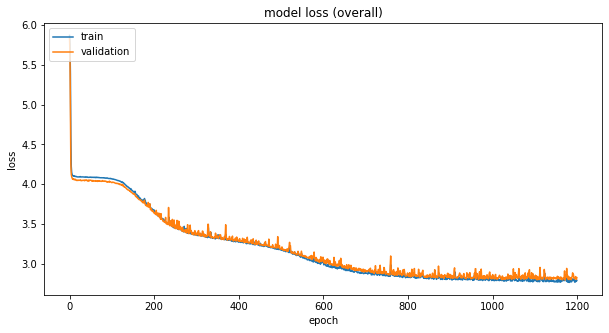

<Figure size 432x288 with 0 Axes>

In [30]:
# Loss 
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss (overall)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()
plt.savefig('/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/source code/DNN/Graph/Overall model loss13.jpeg')

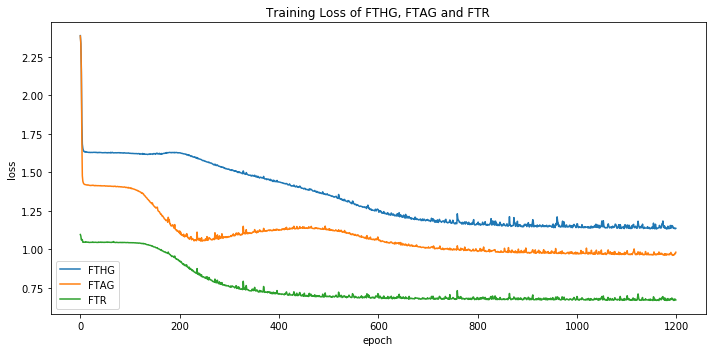

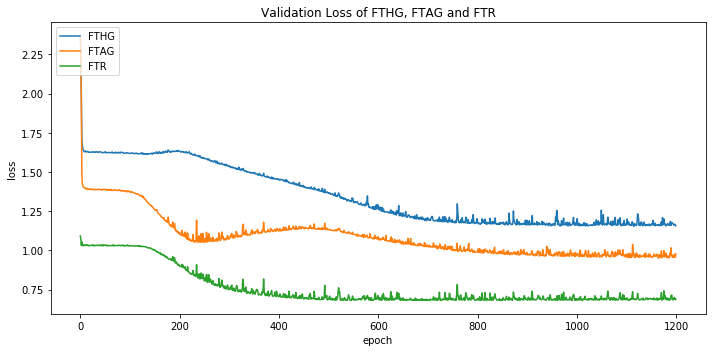

In [31]:
# Loss value of 3 target features

#plt.subplot(1, 2, 1)
plt.figure(figsize=(10, 5))
plt.plot(history.history['dense_4_loss'])
plt.plot(history.history['dense_5_loss'])
plt.plot(history.history['dense_6_loss'])
plt.title('Training Loss of FTHG, FTAG and FTR')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['FTHG','FTAG','FTR'], loc='lower left')
plt.savefig('/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/source code/DNN/Graph/model_loss(3 target output)13.jpeg')
plt.tight_layout()
plt.show()

#plt.subplot(1, 2, 2)
plt.figure(figsize=(10, 5))
plt.plot(history.history['val_dense_4_loss'])
plt.plot(history.history['val_dense_5_loss'])
plt.plot(history.history['val_dense_6_loss'])
plt.title('Validation Loss of FTHG, FTAG and FTR')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['FTHG','FTAG','FTR'], loc='upper left')
plt.savefig('/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/source code/DNN/Graph/model_val_loss(3 target output)13.jpeg')
plt.tight_layout()
plt.show()

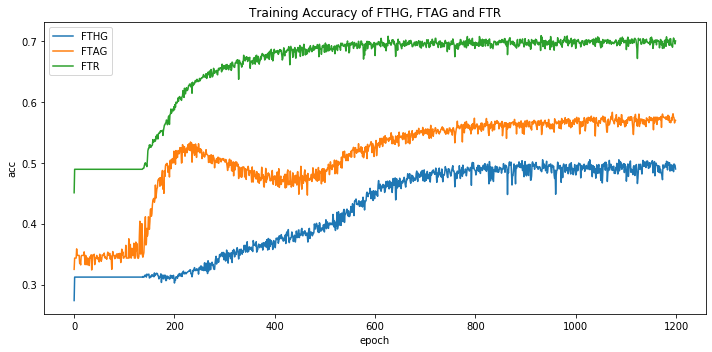

In [32]:
# acc value of 3 target features

plt.figure(figsize=(10, 5))
plt.plot(history.history['dense_4_acc'])
plt.plot(history.history['dense_5_acc'])
plt.plot(history.history['dense_6_acc'])
plt.title('Training Accuracy of FTHG, FTAG and FTR')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['FTHG','FTAG','FTR'], loc='upper left')
plt.savefig('/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/source code/DNN/Graph/model_acc(3 target output)13.jpeg')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history['val_dense_4_acc'])
plt.plot(history.history['val_dense_5_acc'])
plt.plot(history.history['val_dense_6_acc'])
plt.title('Validation Accuracy of FTHG, FTAG and FTR')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['FTHG','FTAG','FTR'], loc='lower left')
plt.savefig('/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/source code/DNN/Graph/model_val_acc(3 target output)13.jpeg')
plt.tight_layout()
plt.show()

In [0]:
# save model

In [0]:
model.save('/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/Model/DNN_model13.hdf5')

In [0]:
# load
#model = load_model('my_model.h5')

In [0]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
# https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/
# https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/66922
# https://www.tensorflow.org/guide/keras/train_and_evaluate
# https://stackoverflow.com/questions/58918390/neural-network-is-not-giving-the-expected-output-after-training-in-python